# Implement IR system based on Vector Space Model on CISI with sklearn

The CISI dataset can be donwloaded at the following address: [CISI dataset](https://www.kaggle.com/datasets/dmaso01dsta/cisi-a-dataset-for-information-retrieval/code?select=CISI.REL)

In this example, we access a local, parsed version of CISI stored in MongoDb

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
from pymongo import MongoClient

In [3]:
db = MongoClient()['cisi']

## Get documents, queries and ground truth

In [4]:
from collections import defaultdict

In [5]:
documents = [(r['id'], ". ".join([r['.T'], r['.W']])) for r in db['documents'].find()]
queries = [(r['id'], r['.W']) for r in db['queries'].find()]

In [6]:
ground_truth = defaultdict(list)

for r in db['rel'].find():
    ground_truth[r['query']].append(r['doc'])

## Tokenization

In [7]:
from nltk.tokenize import word_tokenize

In [8]:
_, doc = documents[1]
tokens = word_tokenize(doc)

In [9]:
tokens[:10]

['Use',
 'Made',
 'of',
 'Technical',
 'Libraries',
 '.',
 'This',
 'report',
 'is',
 'an']

## Tokenization and Normalization using spaCy

In [10]:
import spacy
from spacy.displacy import render
nlp = spacy.load('en_core_web_lg')

In [11]:
print(doc)

Use Made of Technical Libraries. This report is an analysis of 6300 acts of use in 104 technical libraries in the United Kingdom. Library use is only one aspect of the wider pattern of information use. Information transfer in libraries is restricted to the use of documents. It takes no account of documents used outside the library, still less of information transferred orally from person to person. The library acts as a channel in only a proportion of the situations in which information is transferred. Taking technical information transfer as a whole, there is no doubt that this proportion is not the major one. There are users of technical information - particularly in technology rather than science - who visit libraries rarely if at all, relying on desk collections of handbooks, current periodicals and personal contact with their colleagues and with people in other organizations. Even regular library users also receive information in other ways.


In [12]:
def tokens_to_dict(spacy_tokens):
    data = []
    for token in spacy_tokens:
        data.append({
            'idx': token.idx, 
            'text': token.text, 
            'lemma': token.lemma_, 
            'pos': token.pos_, 
            'dep': token.dep_
        })
    return data

In [13]:
sdoc = nlp(doc)
alldata = []
for sentence in sdoc.sents:
    alldata += tokens_to_dict(sentence)
pd.DataFrame(alldata).head(20)

,idx,text,lemma,pos,dep
0,0,Use,use,VERB,ROOT
1,4,Made,make,VERB,dobj
2,9,of,of,ADP,prep
3,12,Technical,Technical,PROPN,compound
4,22,Libraries,Libraries,PROPN,pobj
5,31,.,.,PUNCT,punct
6,33,This,this,DET,det
7,38,report,report,NOUN,nsubj
8,45,is,be,AUX,ROOT
9,48,an,an,DET,det


In [14]:
s1 = list(sdoc.sents)[1]
print(s1)
render(s1)

This report is an analysis of 6300 acts of use in 104 technical libraries in the United Kingdom.


In [15]:
for nc in s1.noun_chunks:
    print(nc)

This report
an analysis
6300 acts
use
104 technical libraries
the United Kingdom


In [16]:
for ent in s1.ents:
    print(ent, ent.label_)

6300 CARDINAL
104 CARDINAL
the United Kingdom GPE


In [17]:
def tokenizer(document):
    tokens = []
    for token in nlp(document):
        if token.pos_ in {'PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV'}:
            tokens.append(token.lemma_.lower())
    return tokens

In [18]:
tokenizer(doc)[:10]

['use',
 'make',
 'technical',
 'libraries',
 'report',
 'analysis',
 'act',
 'use',
 'technical',
 'library']

## TfIdf vectorizer

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
doc_ids, docs = [i for i, _ in documents], [x for _, x in documents]

In [21]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer)

In [22]:
X = vectorizer.fit_transform(docs)

In [23]:
features = vectorizer.get_feature_names_out()

In [24]:
Xs = pd.DataFrame(X.toarray(), index=doc_ids, columns=features)

In [25]:
Xs.head()

,%,',",xn",-,-(n,.,..,.b,.c,.k,...,zaltman,zambia,zeller,zhurnal,ziman,zipf,zipfian,zone,zoology,zuckerman
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.096967,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
Xs.loc[1].sort_values(ascending=False).head(10)

edition           0.463827
dewey             0.398812
ddc               0.301802
decimal           0.253410
history           0.201459
healthy           0.176425
eighteenth        0.176425
classification    0.168807
biography         0.160321
spur              0.160321
Name: 1, dtype: float64

In [27]:
q = vectorizer.transform([queries[0][1]])

## Matching

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
M = cosine_similarity(q, X)

In [30]:
ranking = pd.DataFrame(M, columns=doc_ids).T.sort_values(by=[0], ascending=False)

In [31]:
ranking

,0
429,0.316263
722,0.312982
589,0.287146
603,0.264914
1281,0.231270
...,...
740,0.000000
741,0.000000
748,0.000000
749,0.000000


In [32]:
doc_dic = dict(documents)

In [33]:
doc_dic[722]

'Information Transfer Limitations of Titles of Chemical Documents. Some methods of estimating the minimum amounts of information in a document not retrievable through its title are discussed. An analysis of the information transferred by different types of keywords is helpful in planning search strategies, e.g., 30% of chemical substances mentioned in journal articles are not discernable in their titles even when broad class names are used as synonyms. Patents have considerably less informative titles than journal articles. In nuclear science, report titles are also less informative than those of journal articles, but the proportion of reports with completely uninformative titles is now only 10% of the 1957 value. Titles in chemistry are more informative than those in most other fields, but the use of alerting and other services based on titles requires a good understanding of the underlying information transfer principles.'

# Final TfIdf model

In [34]:
def search(query_text, model):
    q = vectorizer.transform([query_text])
    M = cosine_similarity(q, X)
    ranking = pd.DataFrame(M, columns=doc_ids).T.sort_values(by=[0], ascending=False)
    return [(doc_id, score) for doc_id, score in ranking[0].items()]

In [35]:
answers = search(queries[0][1], vectorizer)

## Ranked evaluation

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

In [46]:
doc_ids = [x for x, _ in documents]
y_pred = np.zeros(len(doc_ids))
scores = np.zeros(len(doc_ids))
for doc_id, score in answers:
    i = doc_ids.index(doc_id)
    if score > 0:
        y_pred[i] = 1
        scores[i] = score

In [47]:
q_id = queries[0][0]
gt = ground_truth[q_id]
y_true = np.zeros(len(doc_ids))
for d in gt:
    i = doc_ids.index(i)
    y_true[i] = 1

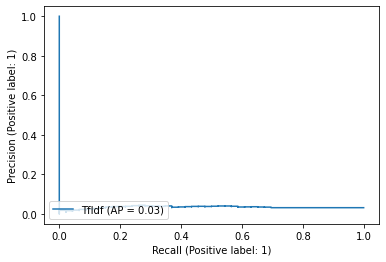

In [48]:
display = PrecisionRecallDisplay.from_predictions(y_true, scores, name="TfIdf")

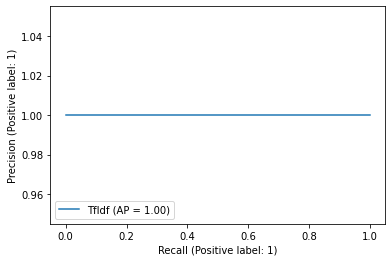

In [49]:
display = PrecisionRecallDisplay.from_predictions(y_true, y_true, name="TfIdf")